# ⏰ Bitcoin Birth TIME Search (with Houses)

Поиск точного времени рождения Bitcoin для даты **2009-10-10**
(первый курс обмена BTC/USD).

## Включает:
- Перебор времени с шагом 5 минут (288 вариантов за день)
- Расчёт домов (куспиды)
- Аспекты транзитных планет к куспидам домов
- Позиции планет в домах

## 1. Setup

In [77]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("/home/rut/ostrofun")
sys.path.insert(0, str(PROJECT_ROOT))

In [78]:
import swisseph as swe
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, timezone
from tqdm import tqdm
from sklearn.metrics import classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_balanced_labels
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_bodies_for_dates_multi,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    calculate_phases_for_dates,
    get_natal_bodies,
    AstroSettings,
    BodyPosition,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    tune_threshold,
    predict_with_threshold,
    check_cuda_available,
)

print("✓ All modules imported")

✓ All modules imported


## 2. House Calculation Functions

In [79]:
# Системы домов
HOUSE_SYSTEMS = {
    "P": "Placidus",
    "K": "Koch", 
    "O": "Porphyry",
    "R": "Regiomontanus",
    "C": "Campanus",
    "E": "Equal",
    "W": "Whole Sign",
}

DEFAULT_HOUSE_SYSTEM = b"P"  # Placidus - самая популярная

# Географические координаты для Bitcoin
# Используем координаты места где Сатоши возможно работал
# Или нейтральные (0, 0) для "глобального" актива
LATITUDE = 0.0   # Экватор - нейтральная позиция
LONGITUDE = 0.0  # Гринвич

In [80]:
def calculate_houses(dt: datetime, lat: float, lon: float, hsys: bytes = DEFAULT_HOUSE_SYSTEM) -> dict:
    """
    Вычисляет куспиды домов для заданного времени и места.
    
    Returns:
        dict с ключами:
        - cusps: list[float] - 12 куспидов домов (градусы зодиака)
        - asc: float - Асцендент
        - mc: float - MC (Medium Coeli)
        - armc: float - ARMC
        - vertex: float - Vertex
        - equasc: float - Equatorial Ascendant
    """
    # Конвертируем в Julian Day
    jd = swe.julday(dt.year, dt.month, dt.day, 
                    dt.hour + dt.minute/60.0 + dt.second/3600.0)
    
    # Рассчитываем дома
    cusps, ascmc = swe.houses(jd, lat, lon, hsys)
    
    return {
        "cusps": list(cusps),  # 12 куспидов (индекс 0 = 1-й дом)
        "asc": ascmc[0],       # Асцендент
        "mc": ascmc[1],        # MC
        "armc": ascmc[2],      # ARMC
        "vertex": ascmc[3],    # Vertex
        "equasc": ascmc[4],    # Equatorial Ascendant
    }

In [81]:
def get_house_positions(bodies: list, cusps: list) -> dict:
    """
    Определяет в каком доме находится каждая планета.
    
    Args:
        bodies: список BodyPosition
        cusps: список из 12 куспидов домов
        
    Returns:
        dict: {body_name: house_number (1-12)}
    """
    result = {}
    
    for body in bodies:
        lon = body.lon
        
        # Определяем дом
        for i in range(12):
            cusp_start = cusps[i]
            cusp_end = cusps[(i + 1) % 12]
            
            # Учитываем переход через 0° Овна
            if cusp_start > cusp_end:
                if lon >= cusp_start or lon < cusp_end:
                    result[body.body] = i + 1
                    break
            else:
                if cusp_start <= lon < cusp_end:
                    result[body.body] = i + 1
                    break
        else:
            result[body.body] = 1  # Fallback
            
    return result

In [82]:
def calculate_aspects_to_cusps(
    transit_bodies: list,
    natal_cusps: list,
    orb: float = 8.0,
) -> pd.DataFrame:
    """
    Вычисляет аспекты транзитных планет к куспидам натальных домов.
    
    Args:
        transit_bodies: список BodyPosition транзитных планет
        natal_cusps: список из 12 куспидов
        orb: орбис в градусах
        
    Returns:
        DataFrame с аспектами к куспидам
    """
    aspects = {
        "Conjunction": 0,
        "Sextile": 60,
        "Square": 90,
        "Trine": 120,
        "Opposition": 180,
    }
    
    cusp_names = [f"Cusp_{i+1}" for i in range(12)]
    cusp_names[0] = "ASC"  # 1-й дом = Асцендент
    cusp_names[9] = "MC"   # 10-й дом = MC
    
    results = []
    
    for body in transit_bodies:
        for i, cusp_lon in enumerate(natal_cusps):
            for asp_name, asp_angle in aspects.items():
                # Разница углов
                diff = abs(body.lon - cusp_lon)
                if diff > 180:
                    diff = 360 - diff
                    
                # Орбис
                orb_diff = abs(diff - asp_angle)
                if orb_diff <= orb:
                    results.append({
                        "transit_body": body.body,
                        "cusp": cusp_names[i],
                        "aspect": asp_name,
                        "orb": orb_diff,
                    })
    
    return pd.DataFrame(results)

In [83]:
def build_house_features(
    transit_bodies: list,
    natal_cusps: list,
    natal_houses: dict,
    orb: float = 8.0,
) -> dict:
    """
    Строит признаки на основе домов.
    
    Returns:
        dict с признаками для одной даты
    """
    features = {}
    
    # 1. Позиции транзитных планет в натальных домах
    transit_houses = get_house_positions(transit_bodies, natal_cusps)
    for body_name, house_num in transit_houses.items():
        # One-hot encoding домов
        for h in range(1, 13):
            features[f"transit_{body_name}_house_{h}"] = 1 if house_num == h else 0
    
    # 2. Аспекты к куспидам
    aspects = {
        "Conjunction": 0,
        "Sextile": 60,
        "Square": 90,
        "Trine": 120,
        "Opposition": 180,
    }
    
    cusp_names = ["ASC", "H2", "H3", "IC", "H5", "H6", "DSC", "H8", "H9", "MC", "H11", "H12"]
    
    for body in transit_bodies:
        for i, cusp_lon in enumerate(natal_cusps):
            for asp_name, asp_angle in aspects.items():
                diff = abs(body.lon - cusp_lon)
                if diff > 180:
                    diff = 360 - diff
                    
                orb_diff = abs(diff - asp_angle)
                # Бинарный признак: есть аспект или нет
                feat_name = f"transit_{body.body}_{asp_name}_{cusp_names[i]}"
                features[feat_name] = 1 if orb_diff <= orb else 0
    
    return features

## 3. Configuration

In [84]:
# ══════════════════════════════════════════════════════════════════════════════════
# ⏰ НАСТРОЙКИ ПОИСКА ВРЕМЕНИ
# ══════════════════════════════════════════════════════════════════════════════════

# Лучшая дата из birthdate_search
BIRTH_DATE = date(2009, 10, 10)

# Шаг поиска времени
TIME_STEP_MINUTES = 5  # каждые 5 минут

# Диапазон времени (UTC)
TIME_START = datetime(2009, 10, 10, 0, 0, 0, tzinfo=timezone.utc)
TIME_END = datetime(2009, 10, 10, 23, 59, 59, tzinfo=timezone.utc)

# Географические координаты
# Хельсинки, Финляндия (Martti Malmi / New Liberty Standard)
# Место первой котировки BTC/USD
LATITUDE, LONGITUDE = 60.1699, 24.9384

# Система домов
HOUSE_SYSTEM = b"P"  # Placidus

# Орбис для аспектов к куспидам
CUSP_ORB = 5.0  # градусов

# Лучшие параметры из предыдущих поисков
BEST_ASTRO_CONFIG = {
    "coord_mode": "both",
    "orb_mult": 0.15,
    "gauss_window": 300,
    "gauss_std": 70.0,
    "exclude_bodies": None,
}

BEST_XGB_PARAMS = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 50,
}

# Подсчёт вариантов
total_minutes = 24 * 60
total_variants = total_minutes // TIME_STEP_MINUTES

print(f"⏰ Birth date: {BIRTH_DATE}")
print(f"   Time range: {TIME_START.strftime('%H:%M')} - {TIME_END.strftime('%H:%M')} UTC")
print(f"   Step: {TIME_STEP_MINUTES} min")
print(f"   Total variants: {total_variants}")
print(f"   Location: lat={LATITUDE}, lon={LONGITUDE}")
print(f"   House system: {HOUSE_SYSTEMS.get(HOUSE_SYSTEM.decode(), 'Unknown')}")

⏰ Birth date: 2009-10-10
   Time range: 00:00 - 23:59 UTC
   Step: 5 min
   Total variants: 288
   Location: lat=60.1699, lon=24.9384
   House system: Placidus


## 4. Load Data

In [85]:
# Load market data
df_market = load_market_data()
DATA_START = "2017-11-01"
df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)

print(f"Market data: {len(df_market)} rows")

Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31
Market data: 3014 rows


In [86]:
# Create labels
df_labels = create_balanced_labels(
    df_market,
    gauss_window=BEST_ASTRO_CONFIG["gauss_window"],
    gauss_std=BEST_ASTRO_CONFIG["gauss_std"],
)
print(f"Labels: {len(df_labels)} rows")

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Labels: 1506 rows


In [87]:
# Initialize
settings = init_ephemeris()
_, device = check_cuda_available()
print(f"Device: {device}")

Device: cuda


## 5. Pre-compute Transit Bodies

In [88]:
print("📍 Pre-computing transit bodies...")

df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
    df_market["date"], settings,
    coord_mode=BEST_ASTRO_CONFIG["coord_mode"],
    progress=True
)
bodies_by_date = geo_by_date

print(f"✓ Transit bodies ready: {len(df_bodies)} rows")

📍 Pre-computing transit bodies...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 14472.94it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 30651.14it/s]


✅ Объединено: 78364 записей из 2 систем координат
✓ Transit bodies ready: 78364 rows


In [89]:
print("\n🌙 Computing phases...")
df_phases = calculate_phases_for_dates(bodies_by_date, progress=True)
print(f"✓ Phases: {len(df_phases)} rows")


🌙 Computing phases...


Calculating phases & elongations: 100%|██████████| 3014/3014 [00:00<00:00, 154764.54it/s]

✅ Рассчитано 3014 дней: фаза Луны + элонгации планет
✓ Phases: 3014 rows


## 6. Time Search Function

In [90]:
def evaluate_birth_time(
    birth_dt: datetime,
    df_market: pd.DataFrame,
    df_labels: pd.DataFrame,
    df_bodies: pd.DataFrame,
    bodies_by_date: dict,
    df_phases: pd.DataFrame,
    settings: AstroSettings,
    config: dict,
    xgb_params: dict,
    lat: float,
    lon: float,
    hsys: bytes,
    cusp_orb: float,
    device: str,
) -> dict:
    """
    Оценка одного времени рождения с учётом домов.
    """
    try:
        # 1. Рассчитываем дома для этого времени
        houses = calculate_houses(birth_dt, lat, lon, hsys)
        natal_cusps = houses["cusps"]
        
        # 2. Получаем натальные позиции планет
        birth_dt_str = birth_dt.strftime("%Y-%m-%dT%H:%M:%S")
        natal_bodies = get_natal_bodies(birth_dt_str, settings)
        
        # 3. Позиции натальных планет в домах
        natal_houses = get_house_positions(natal_bodies, natal_cusps)
        
        # 4. Строим признаки домов для каждой даты
        house_features_list = []
        
        for dt, transit_bodies in bodies_by_date.items():
            # Базовые признаки домов
            hf = build_house_features(
                transit_bodies, natal_cusps, natal_houses, orb=cusp_orb
            )
            hf["date"] = dt
            house_features_list.append(hf)
        
        df_house_features = pd.DataFrame(house_features_list)
        
        # 5. Вычисляем транзиты к натальным планетам
        df_transits = calculate_transits_for_dates(
            bodies_by_date, natal_bodies, settings,
            orb_mult=config["orb_mult"],
            progress=False,
        )
        
        # 6. Вычисляем аспекты между транзитными планетами
        df_aspects = calculate_aspects_for_dates(
            bodies_by_date, settings,
            orb_mult=config["orb_mult"],
            progress=False,
        )
        
        # 7. Строим полные признаки (без домов)
        df_features_base = build_full_features(
            df_bodies,
            df_aspects,
            df_transits=df_transits,
            df_phases=df_phases,
            include_pair_aspects=True,
            include_transit_aspects=True,
            exclude_bodies=config["exclude_bodies"],
        )
        
        # 8. Объединяем с признаками домов
        df_features_base["date"] = pd.to_datetime(df_features_base["date"])
        df_house_features["date"] = pd.to_datetime(df_house_features["date"])
        
        df_features = df_features_base.merge(df_house_features, on="date", how="left")
        df_features = df_features.fillna(0)
        
        # 9. Merge с метками
        df_dataset = merge_features_with_labels(df_features, df_labels)
        
        if len(df_dataset) < 100:
            return {"error": "Too few samples", "birth_time": birth_dt}
        
        # 10. Split
        train_df, val_df, test_df = split_dataset(df_dataset)
        feature_cols = [c for c in df_dataset.columns if c not in ["date", "target"]]
        
        X_train, y_train = prepare_xy(train_df, feature_cols)
        X_val, y_val = prepare_xy(val_df, feature_cols)
        X_test, y_test = prepare_xy(test_df, feature_cols)
        
        # 11. Train
        model = train_xgb_model(
            X_train, y_train, X_val, y_val,
            feature_cols, n_classes=2, device=device,
            **xgb_params
        )
        
        # 12. Tune threshold
        best_t, _ = tune_threshold(model, X_val, y_val, metric="recall_min")
        
        # 13. Predict
        y_pred = predict_with_threshold(model, X_test, threshold=best_t)
        
        # 14. Metrics
        report = classification_report(
            y_test, y_pred, labels=[0, 1],
            target_names=["DOWN", "UP"], output_dict=True, zero_division=0
        )
        
        recall_down = report["DOWN"]["recall"]
        recall_up = report["UP"]["recall"]
        mcc = matthews_corrcoef(y_test, y_pred)
        
        return {
            "birth_time": birth_dt,
            "time_str": birth_dt.strftime("%H:%M"),
            "recall_down": recall_down,
            "recall_up": recall_up,
            "recall_min": min(recall_down, recall_up),
            "recall_gap": abs(recall_down - recall_up),
            "mcc": mcc,
            "threshold": best_t,
            "n_features": len(feature_cols),
            "asc": houses["asc"],
            "mc": houses["mc"],
        }
        
    except Exception as e:
        return {"error": str(e), "birth_time": birth_dt}

## 7. Run Time Search

In [91]:
print("=" * 80)
print("⏰ BIRTH TIME SEARCH (WITH HOUSES)")
print("=" * 80)
print(f"   Date: {BIRTH_DATE}")
print(f"   Variants: {total_variants}")
print()

⏰ BIRTH TIME SEARCH (WITH HOUSES)
   Date: 2009-10-10
   Variants: 288



In [92]:
results = []
best_so_far = {"recall_min": 0, "birth_time": None}

current_time = TIME_START

with tqdm(total=total_variants, desc="Time search") as pbar:
    while current_time <= TIME_END:
        result = evaluate_birth_time(
            current_time,
            df_market, df_labels, df_bodies, bodies_by_date, df_phases,
            settings, BEST_ASTRO_CONFIG, BEST_XGB_PARAMS,
            LATITUDE, LONGITUDE, HOUSE_SYSTEM, CUSP_ORB, device
        )
        results.append(result)
        
        if "error" not in result:
            r_min = result["recall_min"]
            if r_min > best_so_far["recall_min"]:
                best_so_far = result.copy()
                tqdm.write(f"🏆 NEW BEST: {result['time_str']} → R_MIN={r_min:.3f} MCC={result['mcc']:.3f} ASC={result['asc']:.1f}°")
        else:
            if best_so_far["birth_time"] is None: # Only print first few errors
                 tqdm.write(f"❌ Error for {result.get('time_str', 'unknown')}: {result['error']}")
        
        current_time += timedelta(minutes=TIME_STEP_MINUTES)
        pbar.update(1)

Time search:   0%|          | 0/288 [00:00<?, ?it/s]

Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   0%|          | 1/288 [00:03<15:52,  3.32s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3990, gap=0.2260
🏆 NEW BEST: 00:00 → R_MIN=0.527 MCC=0.132 ASC=151.4°
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   1%|          | 2/288 [00:06<14:49,  3.11s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5123, gap=0.0280
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   1%|          | 3/288 [00:09<14:30,  3.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0222
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   1%|▏         | 4/288 [00:12<13:57,  2.95s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4516, gap=0.1100
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   2%|▏         | 5/288 [00:15<14:34,  3.09s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4718, gap=0.0701
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   2%|▏         | 6/288 [00:18<14:14,  3.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.1131
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   2%|▏         | 7/288 [00:21<13:43,  2.93s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5000, gap=0.0813
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   3%|▎         | 8/288 [00:25<15:42,  3.37s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4828, gap=0.0858
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   3%|▎         | 9/288 [00:28<14:55,  3.21s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3202, gap=0.3975
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   3%|▎         | 10/288 [00:31<14:50,  3.20s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5081, gap=0.0240
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   4%|▍         | 11/288 [00:34<14:05,  3.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3750, gap=0.3442
🏆 NEW BEST: 00:50 → R_MIN=0.557 MCC=0.129 ASC=159.1°
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   4%|▍         | 12/288 [00:37<14:31,  3.16s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4828, gap=0.1301
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   5%|▍         | 13/288 [00:40<14:11,  3.10s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4274, gap=0.2376
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   5%|▍         | 14/288 [00:43<14:18,  3.13s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4919, gap=0.1140
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   5%|▌         | 15/288 [00:46<13:56,  3.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.1382
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   6%|▌         | 16/288 [00:49<13:11,  2.91s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1584
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   6%|▌         | 17/288 [00:52<13:07,  2.90s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0226
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   6%|▋         | 18/288 [00:56<15:42,  3.49s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4778, gap=0.0181
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   7%|▋         | 19/288 [00:59<14:51,  3.31s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   7%|▋         | 20/288 [01:02<13:56,  3.12s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1935, gap=0.5749
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   7%|▋         | 21/288 [01:05<14:11,  3.19s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3990, gap=0.2381
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   8%|▊         | 22/288 [01:08<13:57,  3.15s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.1978
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   8%|▊         | 23/288 [01:11<13:25,  3.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0011
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   8%|▊         | 24/288 [01:14<13:07,  2.98s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3350, gap=0.3666
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   9%|▊         | 25/288 [01:17<12:38,  2.89s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0011
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   9%|▉         | 26/288 [01:19<12:14,  2.80s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1758
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:   9%|▉         | 27/288 [01:22<11:55,  2.74s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.2067
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  10%|▉         | 28/288 [01:25<11:50,  2.73s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0526
🏆 NEW BEST: 02:15 → R_MIN=0.559 MCC=0.146 ASC=172.3°
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  10%|█         | 29/288 [01:29<13:50,  3.21s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4960, gap=0.0311
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  10%|█         | 30/288 [01:32<13:16,  3.09s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0338
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  11%|█         | 31/288 [01:35<13:02,  3.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.1315
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  11%|█         | 32/288 [01:37<12:44,  2.99s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  11%|█▏        | 33/288 [01:40<12:18,  2.90s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0190
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  12%|█▏        | 34/288 [01:43<12:29,  2.95s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.1301
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  12%|█▏        | 35/288 [01:46<12:03,  2.86s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4637, gap=0.0979
🏆 NEW BEST: 02:50 → R_MIN=0.565 MCC=0.151 ASC=177.7°
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  12%|█▎        | 36/288 [01:49<12:09,  2.90s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5709
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  13%|█▎        | 37/288 [01:52<11:47,  2.82s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4089, gap=0.2484
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  13%|█▎        | 38/288 [01:54<11:52,  2.85s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3596, gap=0.3218
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  14%|█▎        | 39/288 [01:59<13:47,  3.32s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0383
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  14%|█▍        | 40/288 [02:02<13:04,  3.16s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5419, gap=0.0025
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  14%|█▍        | 41/288 [02:04<12:24,  3.01s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5161, gap=0.0602
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  15%|█▍        | 42/288 [02:08<12:52,  3.14s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.1364
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  15%|█▍        | 43/288 [02:11<12:23,  3.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5323, gap=0.0096
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  15%|█▌        | 44/288 [02:14<12:45,  3.14s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5524, gap=0.0092
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  16%|█▌        | 45/288 [02:17<12:31,  3.09s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4926, gap=0.0759
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  16%|█▌        | 46/288 [02:20<12:28,  3.09s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0719
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  16%|█▋        | 47/288 [02:23<11:47,  2.94s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.1283
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  17%|█▋        | 48/288 [02:25<11:22,  2.85s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4975, gap=0.0509
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  17%|█▋        | 49/288 [02:30<13:04,  3.28s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4187, gap=0.2224
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  17%|█▋        | 50/288 [02:32<12:22,  3.12s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5320, gap=0.0204
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  18%|█▊        | 51/288 [02:35<12:07,  3.07s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0495
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  18%|█▊        | 52/288 [02:38<12:02,  3.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0132
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  18%|█▊        | 53/288 [02:41<11:42,  2.99s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1145
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  19%|█▉        | 54/288 [02:44<11:24,  2.93s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  19%|█▉        | 55/288 [02:47<11:07,  2.86s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4032, gap=0.2864
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  19%|█▉        | 56/288 [02:49<10:43,  2.77s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.0808
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  20%|█▉        | 57/288 [02:52<10:40,  2.77s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3103, gap=0.4316
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2981
Split: Train=2107, Val=451, Test=452


Time search:  20%|██        | 58/288 [02:55<10:42,  2.79s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0123
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  20%|██        | 59/288 [02:58<10:37,  2.79s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0580
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  21%|██        | 60/288 [03:02<12:01,  3.16s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3399, gap=0.3416
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  21%|██        | 61/288 [03:04<11:33,  3.06s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4778, gap=0.0625
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  22%|██▏       | 62/288 [03:07<11:18,  3.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0038
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  22%|██▏       | 63/288 [03:11<11:36,  3.10s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5123, gap=0.0240
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  22%|██▏       | 64/288 [03:13<11:08,  2.99s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0329
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  23%|██▎       | 65/288 [03:16<11:00,  2.96s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4919, gap=0.0746
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  23%|██▎       | 66/288 [03:19<10:46,  2.91s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.0589
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  23%|██▎       | 67/288 [03:22<10:23,  2.82s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4138, gap=0.1548
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  24%|██▎       | 68/288 [03:25<10:28,  2.86s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3941, gap=0.2753
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  24%|██▍       | 69/288 [03:27<10:31,  2.88s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0137
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  24%|██▍       | 70/288 [03:32<12:17,  3.38s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.0414
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  25%|██▍       | 71/288 [03:35<11:45,  3.25s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5161, gap=0.0799
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  25%|██▌       | 72/288 [03:38<11:08,  3.09s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3941, gap=0.2551
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  25%|██▌       | 73/288 [03:40<10:31,  2.94s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4236, gap=0.1691
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  26%|██▌       | 74/288 [03:43<10:07,  2.84s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0155
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  26%|██▌       | 75/288 [03:46<10:17,  2.90s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5123, gap=0.0078
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  26%|██▋       | 76/288 [03:49<09:58,  2.82s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5000, gap=0.0222
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  27%|██▋       | 77/288 [03:51<09:47,  2.78s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5121, gap=0.0495
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  27%|██▋       | 78/288 [03:54<09:45,  2.79s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.1005
🏆 NEW BEST: 06:25 → R_MIN=0.577 MCC=0.159 ASC=210.9°
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  27%|██▋       | 79/288 [03:57<09:45,  2.80s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4153, gap=0.1857
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  28%|██▊       | 80/288 [04:00<10:10,  2.94s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.0710
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  28%|██▊       | 81/288 [04:04<11:30,  3.34s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5242, gap=0.0522
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  28%|██▊       | 82/288 [04:07<10:56,  3.19s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4926, gap=0.0921
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  29%|██▉       | 83/288 [04:10<10:51,  3.18s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5242, gap=0.0374
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  29%|██▉       | 84/288 [04:14<10:48,  3.18s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4355, gap=0.2098
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  30%|██▉       | 85/288 [04:16<10:22,  3.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0683
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  30%|██▉       | 86/288 [04:19<09:51,  2.93s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.1400
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  30%|███       | 87/288 [04:22<09:27,  2.83s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5320, gap=0.0486
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  31%|███       | 88/288 [04:24<09:19,  2.80s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1749
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  31%|███       | 89/288 [04:27<09:09,  2.76s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4315, gap=0.2237
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  31%|███▏      | 90/288 [04:29<08:51,  2.68s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1673
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  32%|███▏      | 91/288 [04:33<09:15,  2.82s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0186
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  32%|███▏      | 92/288 [04:37<10:39,  3.26s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  32%|███▏      | 93/288 [04:40<10:01,  3.09s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  33%|███▎      | 94/288 [04:42<09:24,  2.91s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  33%|███▎      | 95/288 [04:45<09:17,  2.89s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  33%|███▎      | 96/288 [04:48<09:08,  2.86s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4236, gap=0.1893
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  34%|███▎      | 97/288 [04:50<08:37,  2.71s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  34%|███▍      | 98/288 [04:53<08:39,  2.73s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0208
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  34%|███▍      | 99/288 [04:56<09:08,  2.90s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0070
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  35%|███▍      | 100/288 [04:59<08:56,  2.86s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0661
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  35%|███▌      | 101/288 [05:02<08:41,  2.79s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4919, gap=0.0401
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  35%|███▌      | 102/288 [05:04<08:32,  2.76s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4532, gap=0.1436
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  36%|███▌      | 103/288 [05:08<09:53,  3.21s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.1614
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  36%|███▌      | 104/288 [05:12<09:40,  3.15s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4597, gap=0.1118
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  36%|███▋      | 105/288 [05:15<09:40,  3.17s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0876
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  37%|███▋      | 106/288 [05:18<09:16,  3.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0446
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  37%|███▋      | 107/288 [05:20<08:53,  2.95s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0490
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  38%|███▊      | 108/288 [05:23<09:01,  3.01s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5202, gap=0.0463
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  38%|███▊      | 109/288 [05:27<09:10,  3.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5369, gap=0.0034
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  38%|███▊      | 110/288 [05:29<08:34,  2.89s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  39%|███▊      | 111/288 [05:32<08:23,  2.85s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0392
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  39%|███▉      | 112/288 [05:35<08:43,  2.97s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5081, gap=0.0387
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  39%|███▉      | 113/288 [05:39<09:39,  3.31s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0025
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  40%|███▉      | 114/288 [05:42<09:10,  3.16s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3629, gap=0.3218
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  40%|███▉      | 115/288 [05:45<09:03,  3.14s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5419, gap=0.0186
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  40%|████      | 116/288 [05:48<08:44,  3.05s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4758, gap=0.0661
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  41%|████      | 117/288 [05:51<08:35,  3.01s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4718, gap=0.0602
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  41%|████      | 118/288 [05:54<08:24,  2.96s/it]

🎯 Best threshold=0.53, RECALL_MIN=0.4581, gap=0.1225
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  41%|████▏     | 119/288 [05:57<08:29,  3.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0199
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  42%|████▏     | 120/288 [06:00<08:16,  2.95s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5074, gap=0.0934
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  42%|████▏     | 121/288 [06:02<08:02,  2.89s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.1220
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  42%|████▏     | 122/288 [06:05<07:50,  2.83s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4778, gap=0.0947
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  43%|████▎     | 123/288 [06:10<09:06,  3.31s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0701
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  43%|████▎     | 124/288 [06:12<08:33,  3.13s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0208
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  43%|████▎     | 125/288 [06:15<08:18,  3.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5000, gap=0.0468
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  44%|████▍     | 126/288 [06:18<08:07,  3.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.1154
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  44%|████▍     | 127/288 [06:21<08:03,  3.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4581, gap=0.1265
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  44%|████▍     | 128/288 [06:24<07:44,  2.90s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4274, gap=0.1982
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  45%|████▍     | 129/288 [06:27<07:39,  2.89s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4355, gap=0.1951
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  45%|████▌     | 130/288 [06:29<07:39,  2.91s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  45%|████▌     | 131/288 [06:33<07:48,  2.98s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4879, gap=0.0589
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  46%|████▌     | 132/288 [06:37<08:38,  3.32s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  46%|████▌     | 133/288 [06:42<10:13,  3.96s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4355, gap=0.1754
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  47%|████▋     | 134/288 [06:45<08:56,  3.48s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5202, gap=0.0069
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  47%|████▋     | 135/288 [06:47<08:02,  3.15s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0800
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  47%|████▋     | 136/288 [06:49<07:16,  2.87s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.0710
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  48%|████▊     | 137/288 [06:51<06:46,  2.69s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0791
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  48%|████▊     | 138/288 [06:54<06:20,  2.54s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0988
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  48%|████▊     | 139/288 [06:56<06:00,  2.42s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4435, gap=0.1525
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  49%|████▊     | 140/288 [06:58<05:48,  2.36s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4476, gap=0.1633
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  49%|████▉     | 141/288 [07:00<05:40,  2.32s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4435, gap=0.1328
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  49%|████▉     | 142/288 [07:02<05:36,  2.31s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4384, gap=0.1059
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  50%|████▉     | 143/288 [07:05<05:31,  2.29s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  50%|█████     | 144/288 [07:07<05:45,  2.40s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0105
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  50%|█████     | 145/288 [07:10<05:39,  2.38s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.1297
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  51%|█████     | 146/288 [07:13<06:32,  2.77s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0692
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  51%|█████     | 147/288 [07:16<06:10,  2.62s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5000, gap=0.0468
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  51%|█████▏    | 148/288 [07:18<05:57,  2.55s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1678
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  52%|█████▏    | 149/288 [07:20<05:41,  2.46s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4483, gap=0.1162
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  52%|█████▏    | 150/288 [07:22<05:27,  2.37s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4286, gap=0.1884
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  52%|█████▏    | 151/288 [07:25<05:16,  2.31s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4335, gap=0.1713
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  53%|█████▎    | 152/288 [07:27<05:13,  2.30s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5074, gap=0.0047
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  53%|█████▎    | 153/288 [07:29<05:00,  2.23s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  53%|█████▎    | 154/288 [07:31<04:55,  2.20s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4315, gap=0.2040
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  54%|█████▍    | 155/288 [07:33<04:50,  2.19s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3347, gap=0.4042
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  54%|█████▍    | 156/288 [07:36<04:54,  2.23s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4828, gap=0.0656
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  55%|█████▍    | 157/288 [07:38<05:03,  2.31s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5419, gap=0.0186
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  55%|█████▍    | 158/288 [07:40<04:57,  2.29s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5202, gap=0.0365
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  55%|█████▌    | 159/288 [07:44<05:46,  2.69s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.1328
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  56%|█████▌    | 160/288 [07:46<05:23,  2.53s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.1418
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  56%|█████▌    | 161/288 [07:48<05:08,  2.43s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4483, gap=0.1404
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  56%|█████▋    | 162/288 [07:51<05:02,  2.40s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4637, gap=0.1077
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  57%|█████▋    | 163/288 [07:53<04:50,  2.33s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0477
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  57%|█████▋    | 164/288 [07:55<04:51,  2.35s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5040, gap=0.0526
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  57%|█████▋    | 165/288 [07:57<04:42,  2.29s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3992, gap=0.2215
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  58%|█████▊    | 166/288 [08:00<04:35,  2.26s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5222, gap=0.0544
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  58%|█████▊    | 167/288 [08:02<04:31,  2.24s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3990, gap=0.2220
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  58%|█████▊    | 168/288 [08:04<04:32,  2.27s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5172, gap=0.0190
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  59%|█████▊    | 169/288 [08:06<04:33,  2.30s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5271, gap=0.0294
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  59%|█████▉    | 170/288 [08:09<04:27,  2.27s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5320, gap=0.0204
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  59%|█████▉    | 171/288 [08:11<04:21,  2.24s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4433, gap=0.1655
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  60%|█████▉    | 172/288 [08:14<05:09,  2.67s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4581, gap=0.1306
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  60%|██████    | 173/288 [08:17<04:54,  2.56s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4384, gap=0.1422
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  60%|██████    | 174/288 [08:19<04:48,  2.53s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0011
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  61%|██████    | 175/288 [08:21<04:36,  2.45s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4926, gap=0.0517
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  61%|██████    | 176/288 [08:24<04:23,  2.35s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4556, gap=0.1207
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  61%|██████▏   | 177/288 [08:26<04:20,  2.34s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5403, gap=0.0065
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  62%|██████▏   | 178/288 [08:28<04:17,  2.34s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0352
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  62%|██████▏   | 179/288 [08:31<04:11,  2.31s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5040, gap=0.0378
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  62%|██████▎   | 180/288 [08:33<04:07,  2.29s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5282, gap=0.0136
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  63%|██████▎   | 181/288 [08:35<04:06,  2.30s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5123, gap=0.0603
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  63%|██████▎   | 182/288 [08:37<04:02,  2.29s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0235
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  64%|██████▎   | 183/288 [08:40<04:03,  2.32s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5222, gap=0.0262
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  64%|██████▍   | 184/288 [08:42<03:56,  2.27s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0450
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  64%|██████▍   | 185/288 [08:44<03:48,  2.22s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  65%|██████▍   | 186/288 [08:48<04:28,  2.64s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  65%|██████▍   | 187/288 [08:50<04:15,  2.53s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5000, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  65%|██████▌   | 188/288 [08:52<04:04,  2.44s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.1140
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  66%|██████▌   | 189/288 [08:54<03:53,  2.36s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0356
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  66%|██████▌   | 190/288 [08:56<03:46,  2.31s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3498, gap=0.2994
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  66%|██████▋   | 191/288 [08:59<03:37,  2.24s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  67%|██████▋   | 192/288 [09:01<03:35,  2.24s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0481
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  67%|██████▋   | 193/288 [09:03<03:34,  2.26s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0087
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  67%|██████▋   | 194/288 [09:05<03:34,  2.28s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0544
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  68%|██████▊   | 195/288 [09:08<03:28,  2.25s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4433, gap=0.1575
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2978
Split: Train=2107, Val=451, Test=452


Time search:  68%|██████▊   | 196/288 [09:10<03:25,  2.23s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  68%|██████▊   | 197/288 [09:12<03:18,  2.18s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  69%|██████▉   | 198/288 [09:14<03:15,  2.17s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5709
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  69%|██████▉   | 199/288 [09:18<03:53,  2.62s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0612
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  69%|██████▉   | 200/288 [09:20<03:40,  2.51s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4637, gap=0.1176
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  70%|██████▉   | 201/288 [09:22<03:36,  2.49s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5081, gap=0.0190
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  70%|███████   | 202/288 [09:25<03:30,  2.45s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1315
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  70%|███████   | 203/288 [09:27<03:22,  2.39s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5081, gap=0.0240
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  71%|███████   | 204/288 [09:29<03:14,  2.31s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.1135
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  71%|███████   | 205/288 [09:31<03:09,  2.28s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4798, gap=0.1014
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  72%|███████▏  | 206/288 [09:34<03:08,  2.30s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.0889
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  72%|███████▏  | 207/288 [09:36<03:05,  2.29s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5123, gap=0.0119
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  72%|███████▏  | 208/288 [09:38<03:00,  2.26s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  73%|███████▎  | 209/288 [09:40<02:58,  2.25s/it]

🎯 Best threshold=0.53, RECALL_MIN=0.3103, gap=0.4316
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  73%|███████▎  | 210/288 [09:43<02:54,  2.23s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4631, gap=0.1539
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  73%|███████▎  | 211/288 [09:45<02:53,  2.25s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0517
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  74%|███████▎  | 212/288 [09:47<02:48,  2.22s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3842, gap=0.2448
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  74%|███████▍  | 213/288 [09:50<03:15,  2.60s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3892, gap=0.2439
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  74%|███████▍  | 214/288 [09:53<03:02,  2.47s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3266, gap=0.4025
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  75%|███████▍  | 215/288 [09:55<02:54,  2.39s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3054, gap=0.4486
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  75%|███████▌  | 216/288 [09:57<02:49,  2.36s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3645, gap=0.3008
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  75%|███████▌  | 217/288 [09:59<02:41,  2.28s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0806, gap=0.8307
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  76%|███████▌  | 218/288 [10:01<02:34,  2.21s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3547, gap=0.3308
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  76%|███████▌  | 219/288 [10:03<02:32,  2.21s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4516, gap=0.1789
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  76%|███████▋  | 220/288 [10:06<02:32,  2.24s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3793, gap=0.3021
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  77%|███████▋  | 221/288 [10:08<02:29,  2.24s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4315, gap=0.1449
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  77%|███████▋  | 222/288 [10:10<02:25,  2.21s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4153, gap=0.1512
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  77%|███████▋  | 223/288 [10:12<02:24,  2.22s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.1539
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2980
Split: Train=2107, Val=451, Test=452


Time search:  78%|███████▊  | 224/288 [10:15<02:22,  2.22s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5161, gap=0.0159
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  78%|███████▊  | 225/288 [10:17<02:22,  2.26s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5172, gap=0.0150
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  78%|███████▊  | 226/288 [10:21<02:46,  2.69s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5222, gap=0.0423
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  79%|███████▉  | 227/288 [10:23<02:40,  2.63s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0894
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  79%|███████▉  | 228/288 [10:26<02:35,  2.59s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0450
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  80%|███████▉  | 229/288 [10:28<02:27,  2.50s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5074, gap=0.0208
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  80%|███████▉  | 230/288 [10:30<02:21,  2.44s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5025, gap=0.0338
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  80%|████████  | 231/288 [10:33<02:18,  2.42s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4335, gap=0.1794
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  81%|████████  | 232/288 [10:35<02:14,  2.41s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5040, gap=0.0526
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  81%|████████  | 233/288 [10:37<02:10,  2.38s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5222, gap=0.0625
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  81%|████████▏ | 234/288 [10:40<02:06,  2.33s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.1001
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  82%|████████▏ | 235/288 [10:42<02:00,  2.28s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5709
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  82%|████████▏ | 236/288 [10:44<01:57,  2.26s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5709
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  82%|████████▏ | 237/288 [10:46<01:56,  2.27s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0454
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  83%|████████▎ | 238/288 [10:48<01:51,  2.23s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5709
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  83%|████████▎ | 239/288 [10:52<02:09,  2.64s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3871, gap=0.3420
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  83%|████████▎ | 240/288 [10:54<02:00,  2.51s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.1091
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  84%|████████▎ | 241/288 [10:56<01:53,  2.42s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.1422
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  84%|████████▍ | 242/288 [10:59<01:48,  2.36s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3629, gap=0.3711
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2982
Split: Train=2107, Val=451, Test=452


Time search:  84%|████████▍ | 243/288 [11:01<01:43,  2.30s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0137
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  85%|████████▍ | 244/288 [11:03<01:40,  2.28s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4778, gap=0.0544
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  85%|████████▌ | 245/288 [11:05<01:39,  2.31s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5161, gap=0.0159
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  85%|████████▌ | 246/288 [11:08<01:36,  2.30s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4729, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  86%|████████▌ | 247/288 [11:10<01:35,  2.33s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4798, gap=0.0719
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  86%|████████▌ | 248/288 [11:12<01:33,  2.33s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4113, gap=0.2045
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  86%|████████▋ | 249/288 [11:15<01:29,  2.30s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  87%|████████▋ | 250/288 [11:17<01:28,  2.32s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.0988
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  87%|████████▋ | 251/288 [11:19<01:24,  2.28s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4395, gap=0.1861
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  88%|████████▊ | 252/288 [11:23<01:37,  2.70s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4975, gap=0.0549
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  88%|████████▊ | 253/288 [11:25<01:29,  2.56s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5000, gap=0.0369
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  88%|████████▊ | 254/288 [11:28<01:27,  2.57s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4677, gap=0.0396
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  89%|████████▊ | 255/288 [11:30<01:20,  2.43s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4089, gap=0.1919
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  89%|████████▉ | 256/288 [11:32<01:13,  2.31s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  89%|████████▉ | 257/288 [11:34<01:12,  2.33s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0217
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  90%|████████▉ | 258/288 [11:36<01:09,  2.30s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4483, gap=0.1646
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  90%|████████▉ | 259/288 [11:39<01:05,  2.27s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5202, gap=0.0217
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  90%|█████████ | 260/288 [11:41<01:02,  2.25s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5403, gap=0.0065
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  91%|█████████ | 261/288 [11:43<01:00,  2.24s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0352
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  91%|█████████ | 262/288 [11:45<00:59,  2.28s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5271, gap=0.0213
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  91%|█████████▏| 263/288 [11:48<00:57,  2.31s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5764, gap=0.0124
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  92%|█████████▏| 264/288 [11:50<00:54,  2.29s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0172
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  92%|█████████▏| 265/288 [11:52<00:53,  2.32s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.1051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  92%|█████████▏| 266/288 [11:56<01:01,  2.79s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5202, gap=0.0660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  93%|█████████▎| 267/288 [11:59<00:54,  2.61s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0854
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  93%|█████████▎| 268/288 [12:01<00:49,  2.48s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5172, gap=0.0311
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  93%|█████████▎| 269/288 [12:03<00:46,  2.44s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5271, gap=0.0374
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  94%|█████████▍| 270/288 [12:05<00:43,  2.40s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0567
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  94%|█████████▍| 271/288 [12:08<00:40,  2.36s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0070
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  94%|█████████▍| 272/288 [12:10<00:36,  2.31s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0687
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  95%|█████████▍| 273/288 [12:12<00:33,  2.24s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  95%|█████████▌| 274/288 [12:14<00:31,  2.22s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5161, gap=0.0011
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  95%|█████████▌| 275/288 [12:16<00:28,  2.18s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  96%|█████████▌| 276/288 [12:18<00:25,  2.15s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  96%|█████████▌| 277/288 [12:20<00:23,  2.12s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1637
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  97%|█████████▋| 278/288 [12:23<00:21,  2.16s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.3596, gap=0.3460
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  97%|█████████▋| 279/288 [12:26<00:23,  2.64s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4138, gap=0.2314
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  97%|█████████▋| 280/288 [12:29<00:20,  2.58s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4637, gap=0.1274
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  98%|█████████▊| 281/288 [12:31<00:17,  2.49s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4729, gap=0.1158
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  98%|█████████▊| 282/288 [12:33<00:14,  2.38s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4483, gap=0.1445
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  98%|█████████▊| 283/288 [12:35<00:11,  2.31s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.2956, gap=0.4504
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  99%|█████████▊| 284/288 [12:38<00:09,  2.29s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4828, gap=0.0414
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  99%|█████████▉| 285/288 [12:40<00:06,  2.28s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4476, gap=0.0894
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search:  99%|█████████▉| 286/288 [12:42<00:04,  2.20s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.1976, gap=0.5660
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search: 100%|█████████▉| 287/288 [12:44<00:02,  2.22s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0352
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2984
Split: Train=2107, Val=451, Test=452


Time search: 100%|██████████| 288/288 [12:46<00:00,  2.66s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.0524, gap=0.8737


In [93]:
# Results
print("\n" + "=" * 80)
print("📊 TIME SEARCH RESULTS")
print("=" * 80)

df_results = pd.DataFrame([r for r in results if "error" not in r])

if len(df_results) > 0:
    df_results = df_results.sort_values("recall_min", ascending=False)
    
    print("\n🏆 TOP 20 BEST TIMES:")
    print("-" * 80)
    print(f"{'#':<3} {'Time':<8} {'R_MIN':<8} {'R_UP':<8} {'R_DOWN':<8} {'MCC':<8} {'ASC':<8} {'MC':<8}")
    print("-" * 80)
    
    for idx, (i, row) in enumerate(df_results.head(20).iterrows()):
        print(f"{idx+1:<3} {row['time_str']:<8} {row['recall_min']:.3f}    {row['recall_up']:.3f}    "
              f"{row['recall_down']:.3f}    {row['mcc']:.3f}    {row['asc']:.1f}°    {row['mc']:.1f}°")
    
    # Save
    results_path = PROJECT_ROOT / "data" / "market" / "reports" / "birthtime_search_results.csv"
    df_results.to_csv(results_path, index=False)
    print(f"\n💾 Results saved: {results_path}")
    
    best = df_results.iloc[0]
    print(f"\n⏰ BEST BIRTH TIME: {BIRTH_DATE} {best['time_str']} UTC")
    print(f"   R_MIN = {best['recall_min']:.3f}")
    print(f"   MCC   = {best['mcc']:.3f}")
    print(f"   ASC   = {best['asc']:.1f}°")
    print(f"   MC    = {best['mc']:.1f}°")


📊 TIME SEARCH RESULTS

🏆 TOP 20 BEST TIMES:
--------------------------------------------------------------------------------
#   Time     R_MIN    R_UP     R_DOWN   MCC      ASC      MC      
--------------------------------------------------------------------------------
1   20:50    0.577    0.577    0.591    0.168    122.9°    356.8°
2   06:25    0.577    0.577    0.583    0.159    210.9°    137.7°
3   17:25    0.570    0.586    0.570    0.155    84.9°    303.3°
4   14:25    0.570    0.590    0.570    0.160    322.0°    261.3°
5   16:45    0.568    0.568    0.587    0.155    72.8°    293.7°
6   08:20    0.568    0.568    0.583    0.150    228.5°    168.1°
7   13:25    0.568    0.568    0.587    0.155    288.8°    247.3°
8   02:50    0.565    0.586    0.565    0.151    177.7°    86.6°
9   08:15    0.565    0.586    0.565    0.151    227.7°    166.7°
10  17:05    0.565    0.599    0.565    0.164    79.3°    298.5°
11  02:15    0.559    0.559    0.587    0.146    172.3°    78.5°
12  1

## 8. Visualization

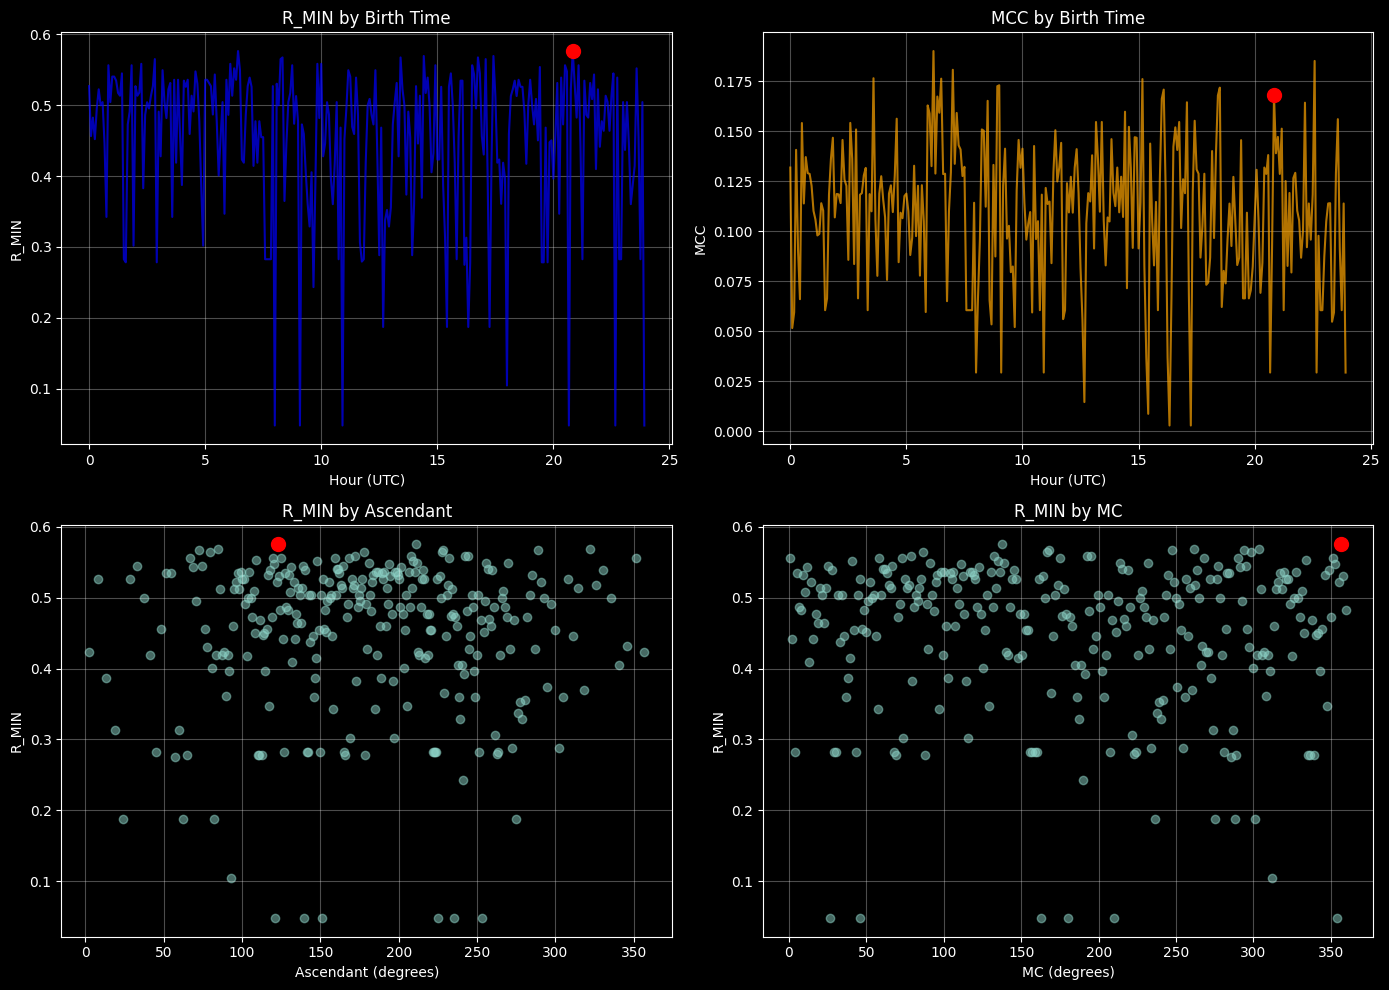

In [94]:
if len(df_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Sort by time for plotting
    df_plot = df_results.sort_values("birth_time")
    hours = [dt.hour + dt.minute/60 for dt in df_plot["birth_time"]]
    
    # R_MIN by time
    ax1 = axes[0, 0]
    ax1.plot(hours, df_plot["recall_min"], 'b-', alpha=0.7)
    ax1.scatter([best["birth_time"].hour + best["birth_time"].minute/60], 
                [best["recall_min"]], c='red', s=100, zorder=5)
    ax1.set_xlabel("Hour (UTC)")
    ax1.set_ylabel("R_MIN")
    ax1.set_title("R_MIN by Birth Time")
    ax1.grid(True, alpha=0.3)
    
    # MCC by time
    ax2 = axes[0, 1]
    ax2.plot(hours, df_plot["mcc"], 'orange', alpha=0.7)
    ax2.scatter([best["birth_time"].hour + best["birth_time"].minute/60], 
                [best["mcc"]], c='red', s=100, zorder=5)
    ax2.set_xlabel("Hour (UTC)")
    ax2.set_ylabel("MCC")
    ax2.set_title("MCC by Birth Time")
    ax2.grid(True, alpha=0.3)
    
    # ASC distribution
    ax3 = axes[1, 0]
    ax3.scatter(df_plot["asc"], df_plot["recall_min"], alpha=0.5)
    ax3.scatter([best["asc"]], [best["recall_min"]], c='red', s=100, zorder=5)
    ax3.set_xlabel("Ascendant (degrees)")
    ax3.set_ylabel("R_MIN")
    ax3.set_title("R_MIN by Ascendant")
    ax3.grid(True, alpha=0.3)
    
    # MC distribution
    ax4 = axes[1, 1]
    ax4.scatter(df_plot["mc"], df_plot["recall_min"], alpha=0.5)
    ax4.scatter([best["mc"]], [best["recall_min"]], c='red', s=100, zorder=5)
    ax4.set_xlabel("MC (degrees)")
    ax4.set_ylabel("R_MIN")
    ax4.set_title("R_MIN by MC")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [95]:
print("\n" + "=" * 80)
print("✅ BIRTH TIME SEARCH COMPLETE!")
print("=" * 80)


✅ BIRTH TIME SEARCH COMPLETE!
